![Astrofisica Computacional](../logo.PNG)

## Estructura Interna de una Enana Blanca
---

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

En este ejercicio se modelará la estructura interna de una enana blanca utilizando las ecuaciones de un modelo simplificado de la estructura estelar. Las ecuaciones básicas son

\begin{align}
\frac{d\rho }{dt} + \boldsymbol{\nabla} \cdot (\rho \textbf{v}) = 0 \hspace{1cm} & \textrm{Ecuación de Continuidad}\\
\rho \big[ \frac{\partial v}{\partial t} + (v \cdot \nabla)\cdot v\big] = - \nabla P + f \hspace{1cm} & \textrm{Conservación del Momentum}\\
\frac{\partial }{\partial t}\left( \frac{1}{2}\rho v^2 + \rho \varepsilon \right) + \nabla \cdot \left[\left( \frac{1}{2} \rho v^2 + \rho \varepsilon + P \right) v \right] = f \cdot v - \nabla \cdot F_{rad} - \nabla \cdot q \hspace{1cm} & \textrm{Conservación de la Energía} \\
P = P(\rho) \hspace{1cm} & \textrm{Ecuación de Estado}
\end{align}

donde 

- $\rho$ : Densidad de masa
- $v$ : Velocidad local del gas
- $P$ : Presión
- $\varepsilon$ : Densidad de energía interna del gas
- $F_{rad}$ : Densidad de energía de radiación
- $q$ : Flujo (conductivo) de calor


En el interior de la enana blanca se considerará equilibrio hidrostático con simetría esférica, lo cual da lugar a las suposiciones:

- $M = M(r)$
- $v = v_r =$ constante
- $f = - \frac{GM \rho}{ r^2}$

De esta forma, las ecuaciones de la hidrodinámica se convierten en:

\begin{align}
\frac{dP}{dr} = - \frac{GM(r)}{r^2} \rho \hspace{1cm} & \textrm{Equilibrio hidrostático}\\
\frac{dM}{dr} = 4\pi \rho r^2 \hspace{1cm} & \textrm{Conservación de la masa}
\end{align}

junto con una ecuación de estado del tipo politrópico,

\begin{equation}
P = K \rho ^\Gamma,
\end{equation}

donde $K$ se denomina la *constante politrópica* y $\Gamma$ es el *índice adiabático* (i.e. la razón entre los calores específicos).

Las eneanas blancas son objetos estelares cuya gravedad esta soportada por la presión de degeneración de electrones. Utilizando un modelo relativista de una enana blanca completamente degenerada, los valores de las constantes en al ecuación de estado son

\begin{align}
K = &1.244 \times 10^{15} \times (0.5)^\Gamma \textrm{ dinas cm}^{-2} \left(\textrm{g}^{-1} \textrm{cm}^3\right)^\Gamma \\
\Gamma = &\frac{4}{3}
\end{align}

El objetivo es integrar las ecuaciones diferenciales desde el interior de la estrella hasta el punto que define su superficie y encontrar las funciones $M(r)$, $\rho (r)$ y $P(r)$. Las condiciones iniciales se tomarán como:

- Densidad en el centro de la estrella: $\rho_c = 10^{10} \textrm{ g cm}^{-3}$
- Presión en el centro de la estrella : $P_c = K \rho_c ^\Gamma$
- Masa en el centro de la estrella : $M(r=0) = 0$

La integración se realizará hasta la superficie de la estrella, al cual está definida por el radio $R_*$ en el cual la presión es nula. Nosotros impondremos la condición

- Presión en la superficie de la estrella: $P (r = R_*) = 10^{-10} P_c$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
%matplotlib inline

In [2]:
# Constantes y parametos globales para las enanas blancas
G = 6.67e-8 # [dyn cm^2 g^-2]
Msun  = 1.99e33 # [g]
Gamma = 4.0/3.0 # Indice adiabatico
K = 1.244e15*(0.5**Gamma) # Constante politrópica [dyn cm^2 g^3/4]

---
### Método de Euler

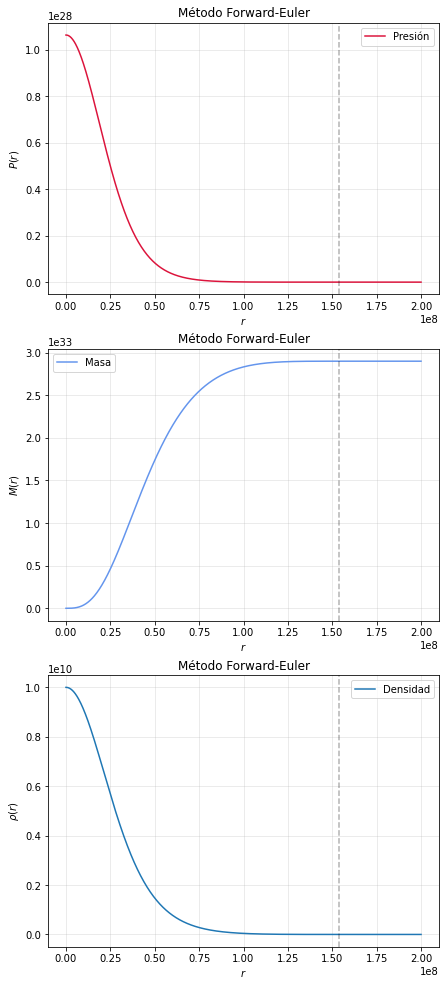

Radio de la estrella de neutrones: 1539.54 km
Masa total: 1.46 Masas Solares

 



In [3]:
# Ecuaciones diferenciales
def ODE(r, q):
    '''
    q: Variables de estado
    Presion = q[0]
    Masa = q[1]
    '''
    p = q[0]
    m = q[1]
    # Ecuación de estado para incluir rho en las ecuaciones diferenciales
    rho = (p/K)**(1/Gamma)

    rhs = np.zeros(2)
    if(r > 1.0e-10): # Para remover la singularidad en r=0
        rhs[0] = -G*m*rho/(r**2) #Equilibrio hidrostatico
        rhs[1] = 4*pi*rho*r**2 #Conservación de la masa
    else:
        rhs[0] = 0.0
        rhs[1] = 0.0
    return rhs



def FEuler(ODE, r, dr, q):
    ''' 
    Integrador Forward-Euler
    con modificación predictor-corrector
    ----------------------------------------
    Presion = q[0]
    Masa = q[1]
    '''
    newq = np.zeros(2)
    # forward-Euler 
    newq = q + dr*ODE(r, q)
    # Inserción de método predictor-corrector
    newq = q + dr/2*(ODE(r, q) + ODE(r, newq)) 
    return newq


# Establece el grid para la integración
npoints = 1000
r_max = 2.0e8 # Radio maximo de 2000 km = 2e8 cm
radius = np.linspace(0, r_max, npoints)
dr = radius[1]-radius[0]

# Establece las variables
q = np.zeros([npoints,2]) #Presion:0,Masa:1
rho = np.zeros(npoints)



#### Condiciones Iniciales ####
rho[0]   = 1.0e10 # [g/cm^3]
q[0,0] = K * rho[0]**Gamma # [dyn/cm^2]
q[0,1]  = 0.0 # [g]

#### Critero para terminar la integración (surface pressure) ####
press_min = 1.0e-10 * q[0,0] 


# Esta variable guardará el índice que define la superficie estelar
n = 0 
# Loop Principal
while q[n,0]>press_min: # Chequear el criterio de terminación
    q[n+1,0],q[n+1,1] = FEuler(ODE, radius[n], dr, q[n])
    rho[n+1] = (q[n+1,0]/K)**(1/Gamma)
    n +=1

# Despues de alcanzar el criterio de finalizacion
# las funciones dejan de cambiar
for i in range(n+1, npoints):
    q[i,0] = q[n,0]
    rho[i]   = rho[n]
    q[i,1]  = q[n,1]

    
# Figura presión vs r
fig, ax = plt.subplots(3,1, figsize=(7,17))
ax[0].plot(radius, q[:,0], color='crimson', label='Presión')
ax[0].set_title('Método Forward-Euler')
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'$P(r)$')
ax[0].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Figura masa vs r
ax[1].plot(radius, q[:,1], color='cornflowerblue', label='Masa')
ax[1].set_title('Método Forward-Euler')
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$M(r)$')
ax[1].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[1].legend()
ax[1].grid(alpha=0.3)

# Figura densidad vs r
ax[2].plot(radius, rho, label='Densidad')
ax[2].set_title('Método Forward-Euler')
ax[2].set_xlabel(r'$r$')
ax[2].set_ylabel(r'$\rho(r)$')
ax[2].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.show()

print(f'Radio de la estrella de neutrones: {radius[n]/1.0e5:.2f} km')
print(f'Masa total: {q[n,1]/Msun:.2f} Masas Solares')
print('\n \n')

---
### Método Runge-Kutta 4

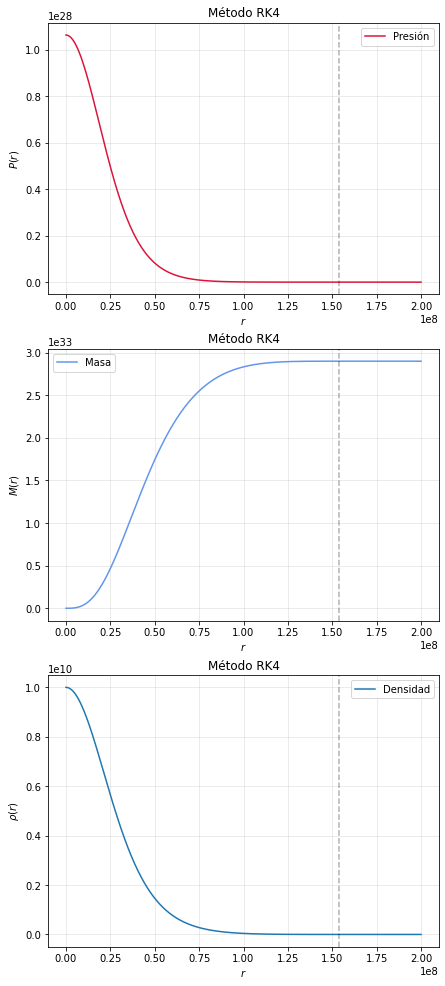

Radio de la estrella de neutrones: 1537.54 km
Masa total: 1.46 Masas Solares

 



In [4]:
# Ecuaciones diferenciales
def ODE(r, q):
    '''
    q: Variables de estado
    Presion = q[0]
    Masa = q[1]
    '''
    p = q[0]
    m = q[1]
    # Ecuación de estado para incluir rho en las ecuaciones diferenciales
    rho = (p/K)**(1/Gamma)

    rhs = np.zeros(2)
    if(r > 1.0e-10): # Para remover la singularidad en r=0
        rhs[0] = -G*m*rho/(r**2) #Equilibrio hidrostatico
        rhs[1] = 4*pi*rho*r**2 #Conservación de la masa
    else:
        rhs[0] = 0.0
        rhs[1] = 0.0
    return rhs


# Método Runge-Kutta 4
def RK4(ODE, r, dr, q):
    '''
    ------------------------------------------
    RK4(ODE, r, dr, q):
    ------------------------------------------
    4th Order Runge-Kutta method for solving 
    a system of ODEs.
    Arguments:
    ODE: function defining the system of ODEs
    ------------------------------------------
    '''
    newq = np.zeros(2)
    k1 = dr*ODE(r, q)
    k2 = dr*ODE(r + dr/2, q + k1/2)
    k3 = dr*ODE(r + dr/2, q + k2/2)
    k4 = dr*ODE(r + dr, q + k3)
    newq = q + (k1 + 2*k2 + 2*k3 + k4)/6

    return newq


# Establece el grid para la integración
npoints = 1000
r_max = 2.0e8 # Radio maximo de 2000 km = 2e8 cm
radius = np.linspace(0, r_max, npoints)
dr = radius[1]-radius[0]

# Establece las variables
q = np.zeros([npoints,2]) #Presion:0,Masa:1
rho   = np.zeros(npoints)



#### Condiciones Iniciales ####
rho[0]   = 1.0e10 # [g/cm^3]
q[0,0] = K * rho[0]**Gamma # [dyn/cm^2]
q[0,1]  = 0.0 # [g]

#### Critero para terminar la integración (surface pressure) ####
press_min = 1.0e-10 * q[0,0] 


# Esta variable guardará el índice que define la superficie estelar
n = 0 
# Loop Principal
while q[n,0]>press_min: # Chequear el criterio de terminación
    q[n+1,0],q[n+1,1] = RK4(ODE, radius[n], dr, q[n])
    rho[n+1] = (q[n+1,0]/K)**(1/Gamma)
    n +=1

# Despues de alcanzar el criterio de finalizacion
# las funciones dejan de cambiar
for i in range(n+1, npoints):
    q[i,0] = q[n,0]
    rho[i]   = rho[n]
    q[i,1]  = q[n,1]

    
# Figura presión vs r
fig, ax = plt.subplots(3,1, figsize=(7,17))
ax[0].plot(radius, q[:,0], color='crimson', label='Presión')
ax[0].set_title('Método RK4')
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'$P(r)$')
ax[0].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Figura masa vs r
ax[1].plot(radius, q[:,1], color='cornflowerblue', label='Masa')
ax[1].set_title('Método RK4')
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$M(r)$')
ax[1].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[1].legend()
ax[1].grid(alpha=0.3)

# Figura densidad vs r
ax[2].plot(radius, rho, label='Densidad')
ax[2].set_title('Método RK4')
ax[2].set_xlabel(r'$r$')
ax[2].set_ylabel(r'$\rho(r)$')
ax[2].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.show()

print(f'Radio de la estrella de neutrones: {radius[n]/1.0e5:.2f} km')
print(f'Masa total: {q[n,1]/Msun:.2f} Masas Solares')
print('\n \n')


---
### ODEINT

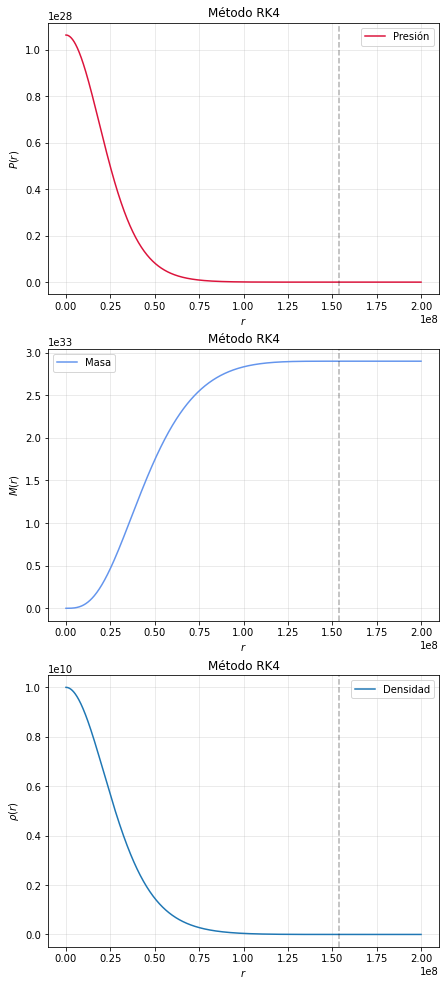

Radio de la estrella de neutrones: 1537.54 km
Masa total: 1.46 Masas Solares

 



In [5]:
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

# Ecuaciones diferenciales
def ODE(r, q):
    '''
    q: Variables de estado
    Presion = q[0]
    Masa = q[1]
    '''
    p = q[0]
    m = q[1]
    # Ecuación de estado para incluir rho en las ecuaciones diferenciales
    rho = (p/K)**(1/Gamma)

    rhs = np.zeros(2)
    if(r > 1.0e-10): # Para remover la singularidad en r=0
        rhs[0] = -G*m*rho/(r**2) #Equilibrio hidrostatico
        rhs[1] = 4*pi*rho*r**2 #Conservación de la masa
    else:
        rhs[0] = 0.0
        rhs[1] = 0.0
    return rhs



# Establece el grid para la integración
npoints = 1000
r_max = 2.0e8 # Radio maximo de 2000 km = 2e8 cm
radius = np.linspace(0, r_max, npoints)
dr = radius[1]-radius[0]


#### Condiciones Iniciales ####
rho0 = 1.0e10 # [g/cm^3]
q_ini = np.zeros(2)
q_ini[0] = K * rho0**Gamma # [dyn/cm^2]
q_ini[1]  = 0.0 # [g]

#### Critero para terminar la integración (surface pressure) ####
press_min = 1.0e-10 * q_ini[0] 


 
# Integración con ODEINT
q = odeint(ODE, q_ini, radius, tfirst=True)


# Chequear el criterio de terminación
n=0
while q[n,0]>press_min:
    n+=1

# Despues de alcanzar el criterio de finalizacion
# las funciones dejan de cambiar
for i in range(n+1, npoints):
    q[i,0] = q[n,0]
    q[i,1]  = q[n,1]

# Calculo del perfil de densidad
rho = (q[:,0]/K)**(1/Gamma)
    
# Figura presión vs r
fig, ax = plt.subplots(3,1, figsize=(7,17))
ax[0].plot(radius, q[:,0], color='crimson', label='Presión')
ax[0].set_title('Método RK4')
ax[0].set_xlabel(r'$r$')
ax[0].set_ylabel(r'$P(r)$')
ax[0].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Figura masa vs r
ax[1].plot(radius, q[:,1], color='cornflowerblue', label='Masa')
ax[1].set_title('Método RK4')
ax[1].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$M(r)$')
ax[1].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[1].legend()
ax[1].grid(alpha=0.3)

# Figura densidad vs r
ax[2].plot(radius, rho, label='Densidad')
ax[2].set_title('Método RK4')
ax[2].set_xlabel(r'$r$')
ax[2].set_ylabel(r'$\rho(r)$')
ax[2].axvline(radius[n], color='black',alpha=0.3, linestyle='--')
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.show()

print(f'Radio de la estrella de neutrones: {radius[n]/1.0e5:.2f} km')
print(f'Masa total: {q[n,1]/Msun:.2f} Masas Solares')
print('\n \n')



In [6]:
rho

array([1.00000000e+10, 9.99960519e+09, 9.99842090e+09, 9.99644746e+09,
       9.99368548e+09, 9.99013578e+09, 9.98579942e+09, 9.98067771e+09,
       9.97477218e+09, 9.96808460e+09, 9.96061696e+09, 9.95237149e+09,
       9.94335066e+09, 9.93355715e+09, 9.92299388e+09, 9.91166398e+09,
       9.89957083e+09, 9.88671799e+09, 9.87310928e+09, 9.85874871e+09,
       9.84364052e+09, 9.82778914e+09, 9.81119924e+09, 9.79387567e+09,
       9.77582349e+09, 9.75704796e+09, 9.73755456e+09, 9.71734891e+09,
       9.69643689e+09, 9.67482450e+09, 9.65251797e+09, 9.62952370e+09,
       9.60584825e+09, 9.58149837e+09, 9.55648097e+09, 9.53080313e+09,
       9.50447208e+09, 9.47749523e+09, 9.44988011e+09, 9.42163443e+09,
       9.39276603e+09, 9.36328288e+09, 9.33319311e+09, 9.30250495e+09,
       9.27122677e+09, 9.23936709e+09, 9.20693450e+09, 9.17393773e+09,
       9.14038562e+09, 9.10628709e+09, 9.07165120e+09, 9.03648706e+09,
       9.00080390e+09, 8.96461102e+09, 8.92791781e+09, 8.89073372e+09,
      

### **Distribución de masa de la enana blanca**

In [7]:
from scipy.interpolate import interp1d

rho_interp = interp1d(radius,rho)

In [12]:
rho_interp(1.5e8)

array(11590.29363656)

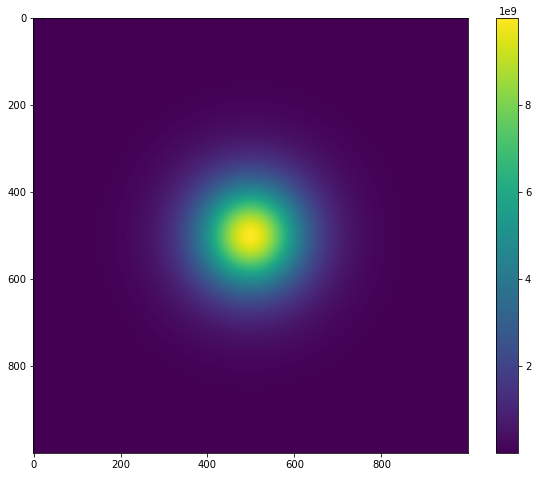

In [13]:
n_pix = 1000
rm = 1.4e8

x = np.linspace(-rm,rm, n_pix)
y = np.linspace(-rm,rm, n_pix)

density_mat = np.zeros([n_pix,n_pix])

for i in range(n_pix):
    for j in range(n_pix):
        r = np.sqrt(x[i]**2 + y[j]**2)
        density_mat[i,j] = rho_interp(r)


fig, ax = plt.subplots(figsize=(10,8))
dens_plot = ax.imshow(density_mat)
fig.colorbar(dens_plot)
plt.show()

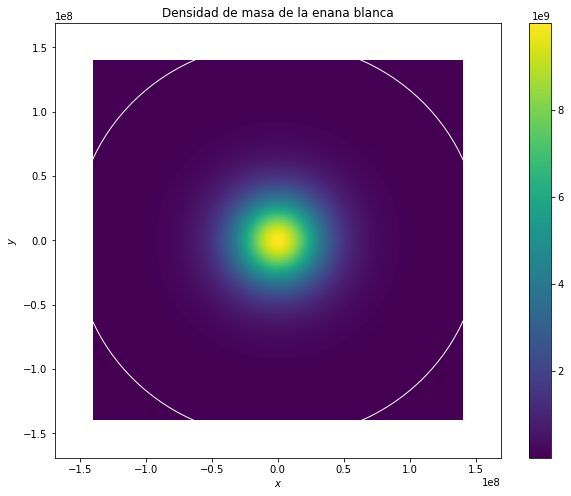

In [14]:

fig, ax = plt.subplots(figsize=(10,8))
densplot = ax.pcolormesh(x, y, density_mat)
circle = plt.Circle((0, 0), 1.537e8, color='w', fill=False)
ax.add_patch(circle)
ax.set_title('Densidad de masa de la enana blanca')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.colorbar(densplot)

plt.show()

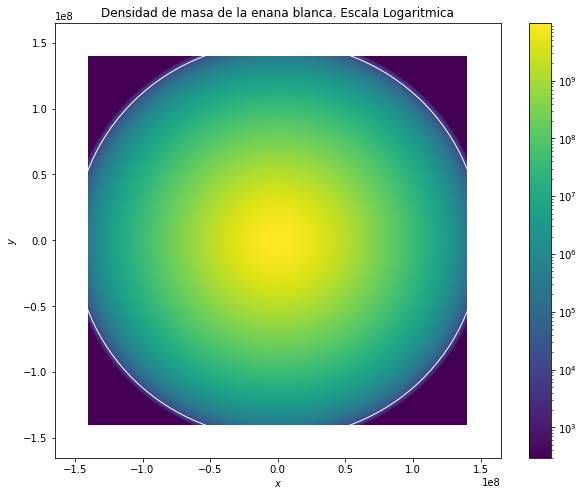

In [15]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(10,8))
densplot = ax.pcolormesh(x, y, density_mat, norm=colors.LogNorm())
circle = plt.Circle((0, 0), 1.5e8,color='w', fill=False)
ax.add_patch(circle)
ax.set_title('Densidad de masa de la enana blanca. Escala Logaritmica')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.colorbar(densplot)

plt.show()